# Семантическая сегментация изображения

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Загрузка изображения 

In [3]:
!wget https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cv/screencast_2/car_bike.jpg

--2021-07-29 00:49:41--  https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cv/screencast_2/car_bike.jpg
Resolving raw.githubusercontent.com... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 371987 (363K) [image/jpeg]
Saving to: 'car_bike.jpg.2'

car_bike.jpg.2      100%[===================>] 363.27K  --.-KB/s    in 0.1s    

2021-07-29 00:49:41 (2.76 MB/s) - 'car_bike.jpg.2' saved [371987/371987]



## Чтение изображения

In [4]:
img_path = "car_bike.jpg"

In [5]:
from PIL import Image
img = Image.open(img_path)

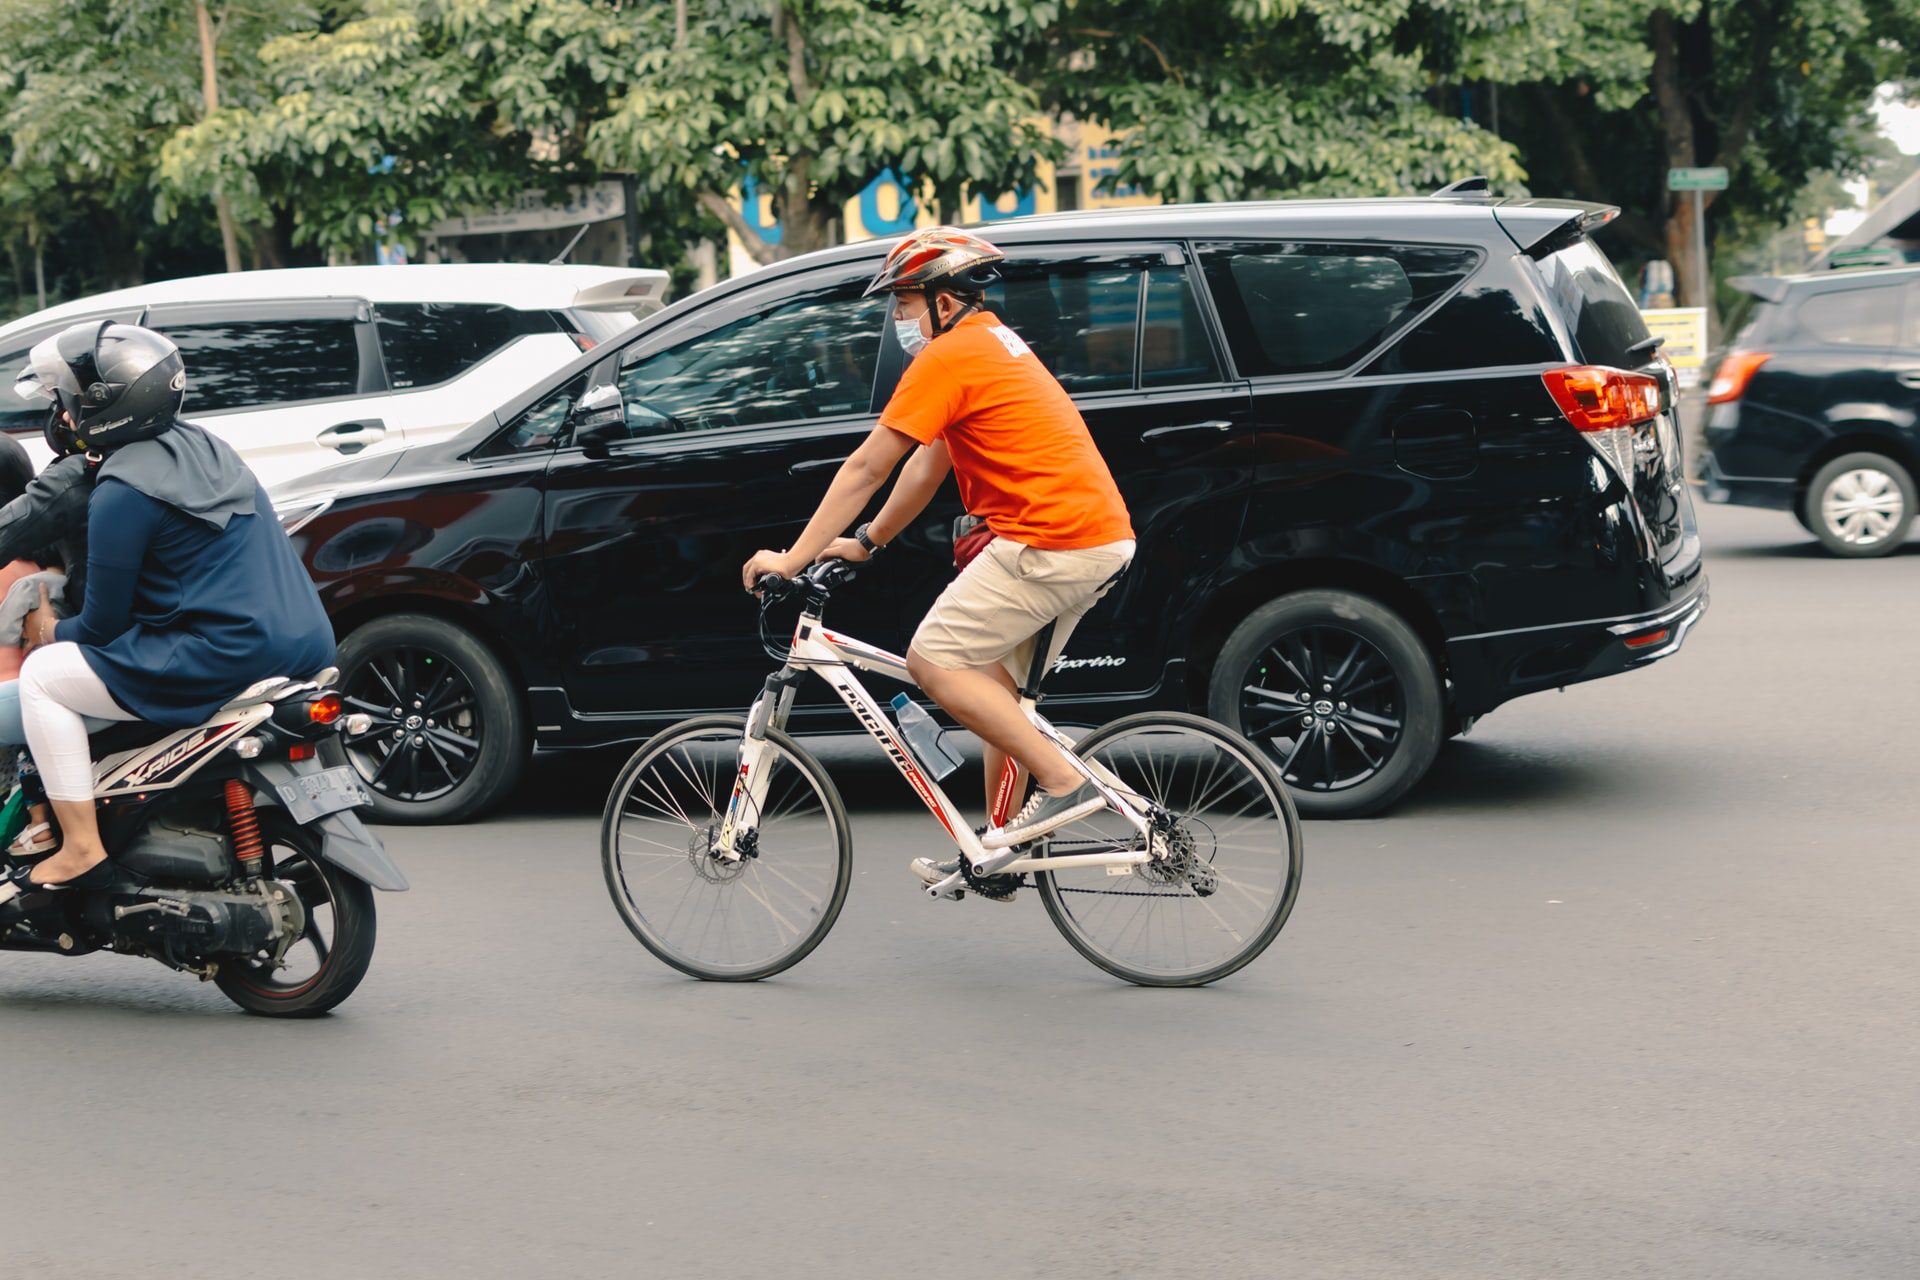

In [6]:
img

## Загрузка DeepLab v3 модели

Модель обучена на наборе данных COCO (https://cocodataset.org/#home) и PASCAL VOC (http://host.robots.ox.ac.uk/pascal/VOC/). Модель сегментирует изображение на 21 класс. 

Подробнее о моделе: https://ai.googleblog.com/2018/03/semantic-image-segmentation-with.html

In [7]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=1)
model = model.eval() # будем только применять, дообучать не будем

Классы объектов, которые умеет находить эта модель:

In [8]:
VOC_INSTANCE_CATEGORY_NAMES = ['__background__', 
                               'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
                               'bus','car', 'cat', 'chair', 'cow', 
                               'diningtable', 'dog', 'horse', 'motorbike', 'person', 
                               'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

## Подготовка изображения

Размер входного изображения может быть любым. Но его надо преобразовать в тензор и нормировать.

In [9]:
import torchvision.transforms as T

transform = T.Compose([T.Resize(512), 
                       T.ToTensor(), 
                       T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
img = transform(img).unsqueeze(0)

In [10]:
img.size() # (число изображений, число каналов, высота, ширина)

torch.Size([1, 3, 512, 768])

## Сегментация изображения

In [11]:
pred = model(img)['out'] 

In [12]:
pred.size() # (число изображений, число классов, высота, ширина)

torch.Size([1, 21, 512, 768])

## Постобработка предсказаний

In [13]:
import torch

# для каждого пикселя выбираем наиболее вероятный класс
output = torch.argmax(pred.squeeze(), dim=0).detach().cpu().numpy()

In [14]:
output.shape # (высота, ширина)

(512, 768)

## Отображение предсказаний

In [15]:
label_colors = np.array([
               (0, 0, 0),  # background
               (128, 0, 0), # aeroplane
               (0, 128, 0), # bicycle
               (128, 128, 0), # bird
               (0, 0, 128), # boat
               (128, 0, 128), # bottle
               (0, 128, 128), # bus 
               (128, 128, 128), # car
               (64, 0, 0), # cat
               (192, 0, 0), # chair
               (64, 128, 0), # cow
               (192, 128, 0), # dining table
               (64, 0, 128), # dog
               (192, 0, 128), # horse
               (64, 128, 128), # motorbike
               (192, 128, 128), # person
               (0, 64, 0), # potted plant
               (128, 64, 0), # sheep
               (0, 192, 0), # sofa
               (128, 192, 0), # train
               (0, 64, 128) # tv/monitor
               ])

In [16]:
# число классов
nc = len(VOC_INSTANCE_CATEGORY_NAMES)

# создаем пустое изображения с 3 каналами
r = np.zeros_like(output).astype(np.uint8)
g = np.zeros_like(output).astype(np.uint8)
b = np.zeros_like(output).astype(np.uint8)

# назначаем цвет каждому пикселю в зависимости от его класса
for l in range(0, nc):
    idx = (output == l)
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]

# собираем каналы в одно изображение    
rgb = np.stack([r, g, b], axis=2)

In [17]:
# снова открываем изображение
img = Image.open(img_path)

# приводим его к нужному размеру
transform = T.Compose([T.Resize(512)])
img = transform(img)

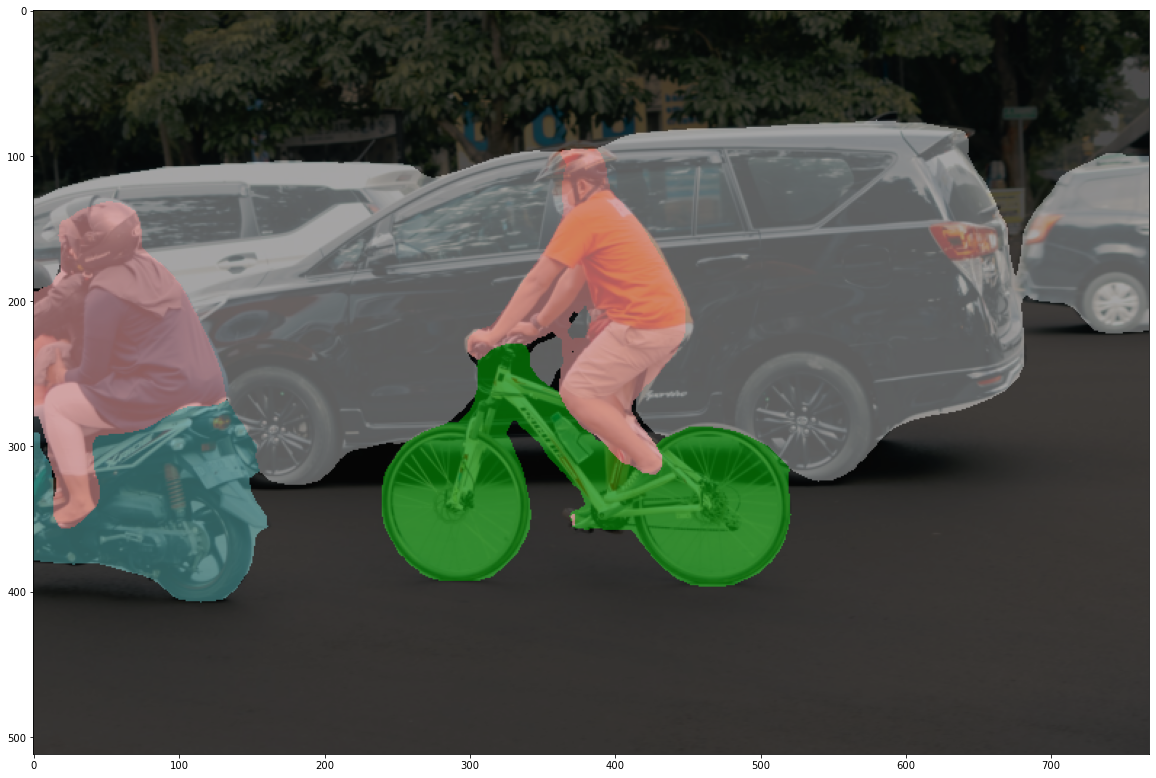

In [18]:
plt.figure(figsize=(20,30))
plt.imshow(np.array(img))  # рисуем первоначальное изображение
plt.imshow(rgb, alpha=0.7) # рисуем результат сегментации
plt.show()